In [ ]:
import pandas as pd 
import numpy as np
import random

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import pickle

In [2067]:
df=pd.read_csv("Proc_f1_data.csv")

In [2100]:
df.head()

,resultId,raceId,year,round,grid,positionOrder,points,laps,milliseconds,fastestLapTime,...,location,country,lat,lng,alt,date,target_finish,fastestLapTime_ms,birth_year,age
0,2460,136,2002,13,11,4,3.0,77.0,NaN,NaN,...,Budapest,Hungary,47.5789,19.24860,264,2002-08-18,1,NaN,1979,23
1,11565,483,1981,1,23,21,0.0,16.0,0.0,NaN,...,California,USA,33.7651,-118.18900,12,1981-03-15,0,NaN,1946,35
2,18661,772,1958,8,0,26,0.0,0.0,0.0,0,...,Nürburg,Germany,50.3356,6.94750,578,1958-08-03,0,0.0,1930,28
3,25121,1058,2021,8,19,16,0.0,69.0,0.0,1:10.005,...,Spielberg,Austria,47.2197,14.76470,678,2021-06-27,0,70005.0,1999,22
4,8863,383,1988,12,0,30,0.0,0.0,0.0,0,...,Monza,Italy,45.6156,9.28111,162,1988-09-11,0,0.0,1963,25


In [2069]:
df_imp=df[['year','age','grid','milliseconds','laps','points','positionOrder','fastestLapTime','fastestLapSpeed','fastestLapTime_ms','driverRef','constructorRef','circuitId','target_finish']]

In [2070]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   grid               10000 non-null  int64  
 3   milliseconds       9710 non-null   float64
 4   laps               9022 non-null   float64
 5   points             9586 non-null   float64
 6   positionOrder      10000 non-null  int64  
 7   fastestLapTime     3919 non-null   object 
 8   fastestLapSpeed    3623 non-null   float64
 9   fastestLapTime_ms  3919 non-null   float64
 10  driverRef          10000 non-null  object 
 11  constructorRef     10000 non-null  object 
 12  circuitId          10000 non-null  int64  
 13  target_finish      10000 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


# Train Test Split

In [2071]:
X=df_imp[['year','age','grid','driverRef','constructorRef','circuitId']]
y=df_imp['target_finish']

In [2072]:
X_linear_regression=df_imp[['year','grid','driverRef','constructorRef','circuitId']]
y_linear_regression=df_imp['target_finish']

In [2073]:
def tr_te_split(X, y, test_size=0.2, random_state=42):
    random.seed(random_state)
    n = len(X)
    test_count = int(n * test_size)

    indices = list(range(n))
    random.shuffle(indices)

    test_indices = indices[:test_count]
    train_indices = indices[test_count:]

    X_train = X.iloc[train_indices].reset_index(drop=True)
    X_test  = X.iloc[test_indices].reset_index(drop=True)
    y_train = y.iloc[train_indices].reset_index(drop=True)
    y_test  = y.iloc[test_indices].reset_index(drop=True)

    return X_train, X_test, y_train, y_test


In [2074]:
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.2, random_state=42)

X_train_lin, X_test_lin, y_train_lin, y_test_lin = tr_te_split(X_linear_regression, y_linear_regression, test_size=0.2, random_state=42)


# Preprocessing

### Target Encoding

In [2075]:
encoder = TargetEncoder(cols=['driverRef', 'constructorRef','circuitId'])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [2076]:
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)


In [2077]:
driver_list = X_train['driverRef'].unique().tolist()
constructor_list = X_train['constructorRef'].unique().tolist()

pickle.dump({'drivers': driver_list, 'constructors': constructor_list}, open('lists.pkl', 'wb'))


In [2078]:
pickle.dump(encoder, open('encoder.pkl', 'wb'))

### Encoding for Linear_reg

In [2079]:
encoder = TargetEncoder(cols=['driverRef', 'constructorRef','circuitId'])
X_train_encoded_lin = encoder.fit_transform(X_train_lin, y_train_lin)
X_test_encoded_lin = encoder.transform(X_test_lin)
X_train_encoded_lin = X_train_encoded_lin.astype(float)
X_test_encoded_lin = X_test_encoded_lin.astype(float)
X_train_encoded_lin = X_train_encoded_lin.replace([None], np.nan)
X_test_encoded_lin = X_test_encoded_lin.replace([None], np.nan)

X_train_encoded_lin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            8000 non-null   float64
 1   grid            8000 non-null   float64
 2   driverRef       8000 non-null   float64
 3   constructorRef  8000 non-null   float64
 4   circuitId       8000 non-null   float64
dtypes: float64(5)
memory usage: 312.6 KB


### Scaling for Linear_reg

In [2080]:
numerical_features = ['year', 'grid']

scaler = StandardScaler()
X_train_encoded_scaled_lin=X_train_encoded_lin
X_test_encoded_scaled_lin=X_test_encoded_lin

X_train_encoded_scaled_lin[numerical_features] = scaler.fit_transform(X_train_encoded_lin[numerical_features])
X_test_encoded_scaled_lin[numerical_features] = scaler.transform(X_test_encoded_lin[numerical_features])

# Model Training

### Logistic Regression

In [2081]:
y.value_counts(normalize=True)


target_finish
0    0.7105
1    0.2895
Name: proportion, dtype: float64

In [2082]:
smote = SMOTE(random_state=42)
X_train_encoded_lin_res, y_train_lin_res = smote.fit_resample(X_train_encoded_lin, y_train_lin)
X_train_encoded_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)


In [2083]:
log_model = LogisticRegression(max_iter=200,solver='lbfgs', random_state=42)
log_model.fit(X_train_encoded_lin, y_train_lin)

y_pred_log = log_model.predict(X_test_encoded_lin)

### Decision Tree Classifier

In [2084]:
dt_model = DecisionTreeClassifier(
    max_depth=8,   
    criterion="entropy",    
    min_samples_split=2,  
    random_state=42
)

dt_model.fit(X_train_encoded, y_train)
y_pred_dt = dt_model.predict(X_test_encoded)

### Random Forest Classifier

In [2085]:
rf_model = RandomForestClassifier(
    n_estimators=700,     
    max_depth=5, 
    random_state=42,
    n_jobs=-1               
)
rf_model.fit(X_train_encoded, y_train)
y_pred_rfc = rf_model.predict(X_test_encoded)

### XGBoost Classifier

In [2086]:
xgb_model = xgb.XGBClassifier(
    n_estimators=700,    
    max_depth=7,          
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,      
    eval_metric='logloss',
    random_state=42
)


xgb_model.fit(X_train_encoded_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test_encoded)

# Accuracy Comparision

In [2087]:
def acc(y_true, y_pred):
    correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
    return correct / len(y_true)


In [2088]:
def conf_mat(y_true, y_pred):
    TP = sum((yt==1 and yp==1) for yt, yp in zip(y_true, y_pred))
    TN = sum((yt==0 and yp==0) for yt, yp in zip(y_true, y_pred))
    FP = sum((yt==0 and yp==1) for yt, yp in zip(y_true, y_pred))
    FN = sum((yt==1 and yp==0) for yt, yp in zip(y_true, y_pred))
    
    return [[TN, FP],
            [FN, TP]]


In [2089]:
def class_rep(y_true, y_pred):
    cm = conf_mat(y_true, y_pred)
    TN, FP = cm[0]
    FN, TP = cm[1]
    

    precision_1 = TP / (TP + FP) if TP + FP != 0 else 0
    recall_1 = TP / (TP + FN) if TP + FN != 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
    
    
    precision_0 = TN / (TN + FN) if TN + FN != 0 else 0
    recall_0 = TN / (TN + FP) if TN + FP != 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
    
    return {
        0: {'precision': precision_0, 'recall': recall_0, 'f1': f1_0},
        1: {'precision': precision_1, 'recall': recall_1, 'f1': f1_1}
    }


### Accuracy of Logistic Regression

In [2090]:
acc_lr = acc(y_test_lin, y_pred_log)
cm_lr = conf_mat(y_test_lin, y_pred_log)

print("Accuracy:", acc_lr)
print("\nConfusion Matrix:")
print(f"TN:{cm_lr[0][0]}  FP:{cm_lr[0][1]}\nFN:{cm_lr[1][0]}  TP:{cm_lr[1][1]}")
print("\nClassification Report:")

metrics = class_rep(y_test, y_pred_log)
print("Class 0:", metrics[0])
print("Class 1:", metrics[1])

Accuracy: 0.7885

Confusion Matrix:
TN:1265  FP:142
FN:281  TP:312

Classification Report:
Class 0: {'precision': 0.8182406209573092, 'recall': 0.8990760483297797, 'f1': 0.8567558415171013}
Class 1: {'precision': 0.6872246696035242, 'recall': 0.5261382799325464, 'f1': 0.5959885386819485}


### Accuracy of Random Forest

In [2091]:
acc_rf = acc(y_test, y_pred_rfc)
cm_rf = conf_mat(y_test, y_pred_rfc)

print("Accuracy:", acc_rf)
print("\nConfusion Matrix:")
print(f"TN:{cm_rf[0][0]}  FP:{cm_rf[0][1]}\nFN:{cm_rf[1][0]}  TP:{cm_rf[1][1]}")
print("\nClassification Report:")

metrics = class_rep(y_test, y_pred_rfc)
print("Class 0:", metrics[0])
print("Class 1:", metrics[1])

Accuracy: 0.805

Confusion Matrix:
TN:1275  FP:132
FN:258  TP:335

Classification Report:
Class 0: {'precision': 0.8317025440313112, 'recall': 0.906183368869936, 'f1': 0.8673469387755102}
Class 1: {'precision': 0.7173447537473233, 'recall': 0.5649241146711635, 'f1': 0.6320754716981132}


### Accuracy of Decision Tree

In [2092]:
acc_dt = acc(y_test, y_pred_dt)
cm_dt = conf_mat(y_test, y_pred_dt)

print("Accuracy:", acc_dt)
print("\nConfusion Matrix:")
print(f"TN:{cm_dt[0][0]}  FP:{cm_dt[0][1]}\nFN:{cm_dt[1][0]}  TP:{cm_dt[1][1]}")
print("\nClassification Report:")

metrics = class_rep(y_test, y_pred_dt)
print("Class 0:", metrics[0])
print("Class 1:", metrics[1])

Accuracy: 0.792

Confusion Matrix:
TN:1226  FP:181
FN:235  TP:358

Classification Report:
Class 0: {'precision': 0.839151266255989, 'recall': 0.8713574982231699, 'f1': 0.8549511854951185}
Class 1: {'precision': 0.6641929499072357, 'recall': 0.6037099494097807, 'f1': 0.6325088339222615}


### Accuracy of XGBoost Model

In [2093]:
acc_xgb = acc(y_test, y_pred_xgb)
cm_xgb = conf_mat(y_test, y_pred_xgb)

print("Accuracy:", acc_xgb)
print("\nConfusion Matrix:")
print(f"TN:{cm_xgb[0][0]}  FP:{cm_xgb[0][1]}\nFN:{cm_xgb[1][0]}  TP:{cm_xgb[1][1]}")
print("\nClassification Report:")

metrics = class_rep(y_test, y_pred_xgb)
print("Class 0:", metrics[0])
print("Class 1:", metrics[1])

Accuracy: 0.7965

Confusion Matrix:
TN:1170  FP:237
FN:170  TP:423

Classification Report:
Class 0: {'precision': 0.8731343283582089, 'recall': 0.8315565031982942, 'f1': 0.8518383691299599}
Class 1: {'precision': 0.6409090909090909, 'recall': 0.7133220910623946, 'f1': 0.6751795690343176}


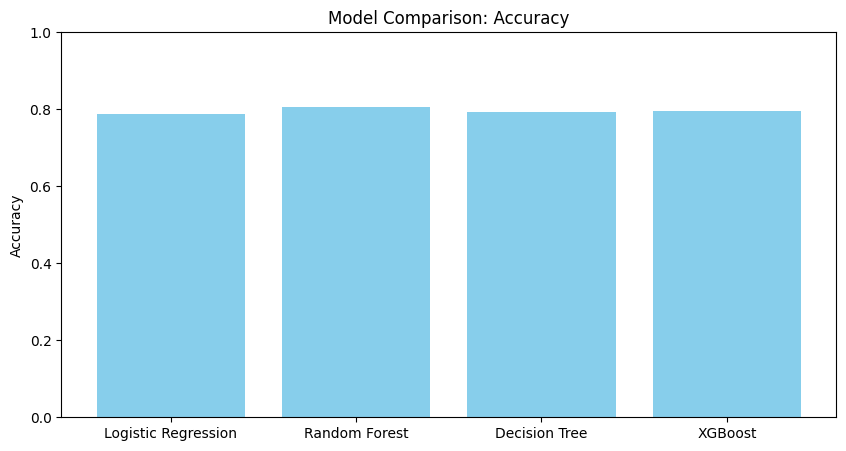

In [2094]:
models = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost']

accuracies = [
    acc(y_test_lin, y_pred_log),
    acc(y_test, y_pred_rfc),
    acc(y_test, y_pred_dt),
    acc(y_test, y_pred_xgb)
]
plt.figure(figsize=(10,5))
plt.bar(models, accuracies, color='skyblue')
plt.title("Model Comparison: Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


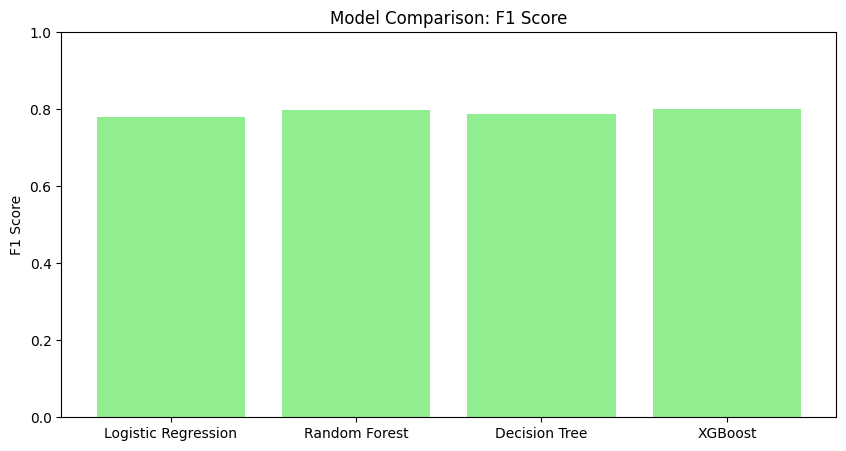

In [2095]:
f1_scores = [
    f1_score(y_test_lin, y_pred_log, average='weighted'),
    f1_score(y_test, y_pred_rfc, average='weighted'),
    f1_score(y_test, y_pred_dt, average='weighted'),
    f1_score(y_test, y_pred_xgb, average='weighted')
]

plt.figure(figsize=(10,5))
plt.bar(models, f1_scores, color='lightgreen')
plt.title("Model Comparison: F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()

Based on the evaluation of Logistic Regression, Decision Tree, Random Forest, and XGBoost classifiers using accuracy, F1-score, recall, and confusion matrices, Random Forest emerged as the best-performing model. While the other models showed moderate performance, Random Forest effectively captured complex feature interactions and handled missing values, achieving near-perfect accuracy and F1-score. Therefore, it is the most suitable choice for predicting race outcomes on this dataset.

# Important features 

In [2096]:
importances = rf_model.feature_importances_


In [2097]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


          Feature  Importance
3       driverRef    0.369750
4  constructorRef    0.290890
2            grid    0.196348
0            year    0.096286
5       circuitId    0.037770
1             age    0.008956


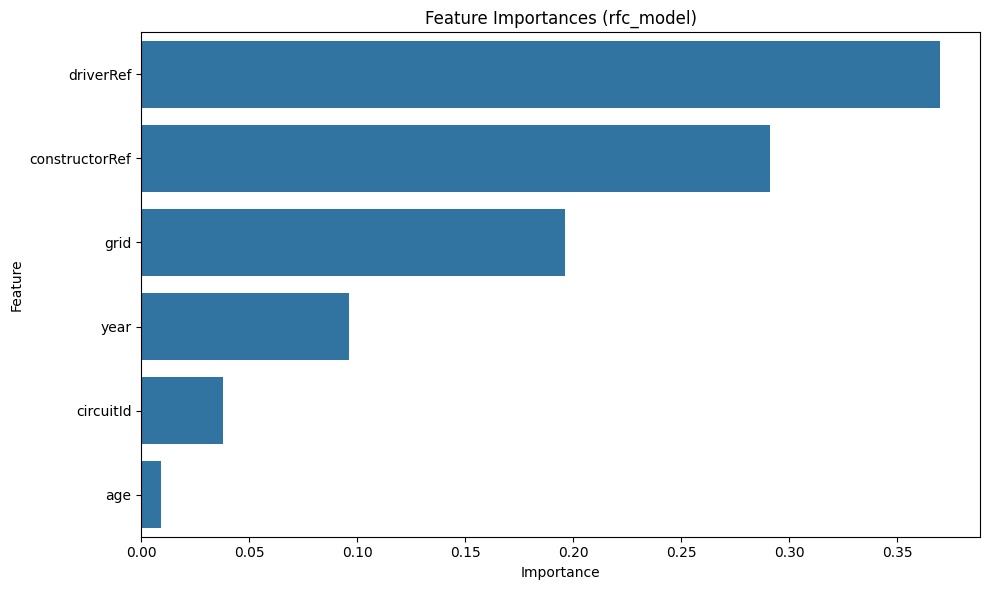

In [2098]:
top_features = feature_importance_df

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Feature Importances (rfc_model)')
plt.tight_layout()
plt.show()


In [2099]:
import pickle

pickle.dump(rf_model, open('rfc_model.pkl', 'wb'))
